In [1]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
D = 1 #Difusion constant
z =10 # Initial condition (bias)
v = .1 #Drift
alpha = 12 # upper barrier value
N = 10000
t_mc = [0] * N 
dt = 0.01

In [3]:
for i in range(1, N):
   x = z
   n = 0
   while x > 0:
      x = x - v * dt + D ** .5 * np.random.normal() * dt**0.5
      n = n + 1
      if x > alpha:
         x = z
         n = 0
   t_mc[i] = n * dt

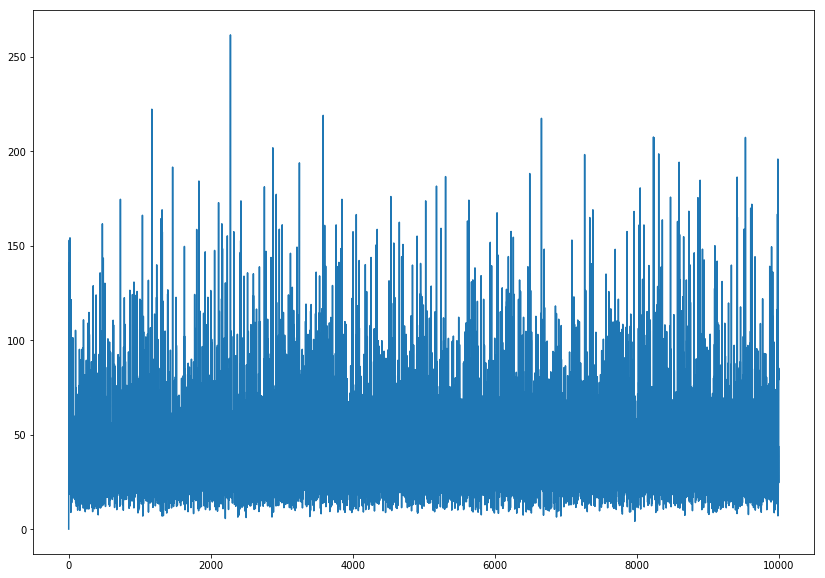

In [4]:
plt.figure(figsize = (14,10))
plt.plot(t_mc)

In [158]:
## Second method

#Simulate random walk with a drift. 
#You start from z and in each time step you add a random number from Gaussian distribution
#and constant drift v towards one of the decisions. 
#You continue until you cross one of the barriers a or -a and note that as a decision time with the decision. 
#Then fit this distribution fro which you know exactly z, v and a using the package.
rounds = 1
sim = pd.DataFrame()

for r in range(rounds):
    subjects = 10
    dec_times = [0] * subjects
    responses = [0] * subjects
    for sub in range(subjects):
        z = 2.1263 # Initial condition (bias)
        v = -0.0627876  # Drift
        a = 3.3668  # upper barrier value
        N = 100000
        t0 = 0.784272  # non decision time
        s = z  # deliberation status
        D = 1 #Difusion constant
        for i in range(N):
            rand = np.random.normal()
            if (s < a) and s > 0:
                s = s - v * t0 + D ** .5 * np.random.randn() * t0**0.5
                #dt = dt + 1
            else:
                if s > 0:
                    responses[sub] = 1
                dec_times[sub] = t0 * i
                break
        if dec_times[sub] == 0.0:
            print ("no decision")
                
    dic = {"round": range(subjects), "rt": dec_times, 'response': responses}
    sim_times = pd.DataFrame(dic)
    if r == 0:
        sim = sim_times
    else:
        sim = sim.append(sim_times, ignore_index = True)

In [159]:
sim.loc[sim.response == 1, "rt"].mean()

4.705632

In [160]:
sim.loc[sim.response == 0, "rt"].mean()

6.078108

In [161]:
sim.to_csv("sim_times.csv")

In [162]:
#Load to HDDM

sim = hddm.load_csv("sim_times.csv")
sim = data = hddm.utils.flip_errors(sim)
sim

,Unnamed: 0,response,round,rt
0,0,0,0,-7.842720
1,1,1,1,1.568544
2,2,1,2,1.568544
3,3,1,3,2.352816
4,4,0,4,-6.274176
5,5,1,5,2.352816
6,6,0,6,-1.568544
7,7,1,7,1.568544
8,8,1,8,18.822528
9,9,0,9,-8.626992


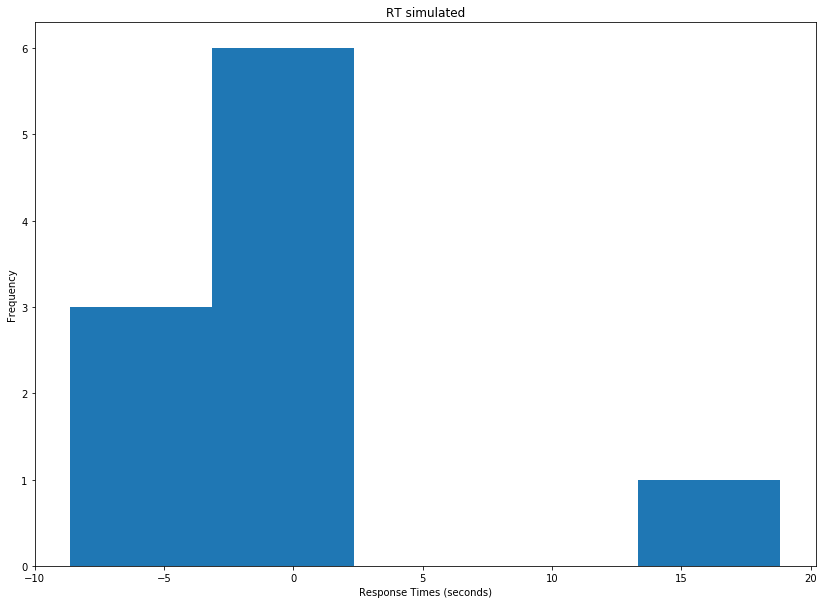

In [163]:
plt.figure(figsize = (14,10))
plt.hist(sim.rt, bins = "auto")
plt.xlabel("Response Times (seconds)")
plt.ylabel("Frequency")
plt.title("RT simulated")
plt.show()

In [164]:
sim

,Unnamed: 0,response,round,rt
0,0,0,0,-7.842720
1,1,1,1,1.568544
2,2,1,2,1.568544
3,3,1,3,2.352816
4,4,0,4,-6.274176
5,5,1,5,2.352816
6,6,0,6,-1.568544
7,7,1,7,1.568544
8,8,1,8,18.822528
9,9,0,9,-8.626992


In [171]:
#model = hddm.HDDM(sim, bias = True)
models = list()
for i in range(100):
    model = hddm.HDDM(sim, bias = True)
    model.sample(5000, burn = 100)
    models.append(model)
hddm.analyze.gelman_rubin(models)

 [-----------------100%-----------------] 5000 of 5000 complete in 9.0 secc

{'a': 1.0000263780051077,
 't': 1.0000118184861426,
 'v': 1.0000572503175391,
 'z_trans': 1.0000560366657727}

Text(0.5,1,'Threshold of 10 rounds synthetic data')

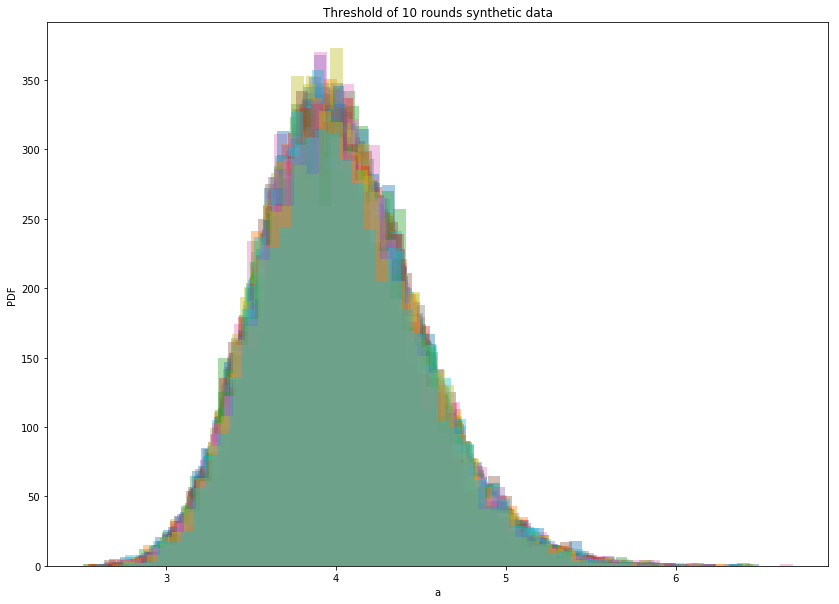

In [172]:
plt.figure(figsize = (14,10))
for m in models:
    sns.distplot(m.get_traces().a, kde = False)
plt.ylabel("PDF")
plt.title("Threshold of 10 rounds synthetic data")

Text(0.5,1,'Drift speed of 10 rounds synthetic data')

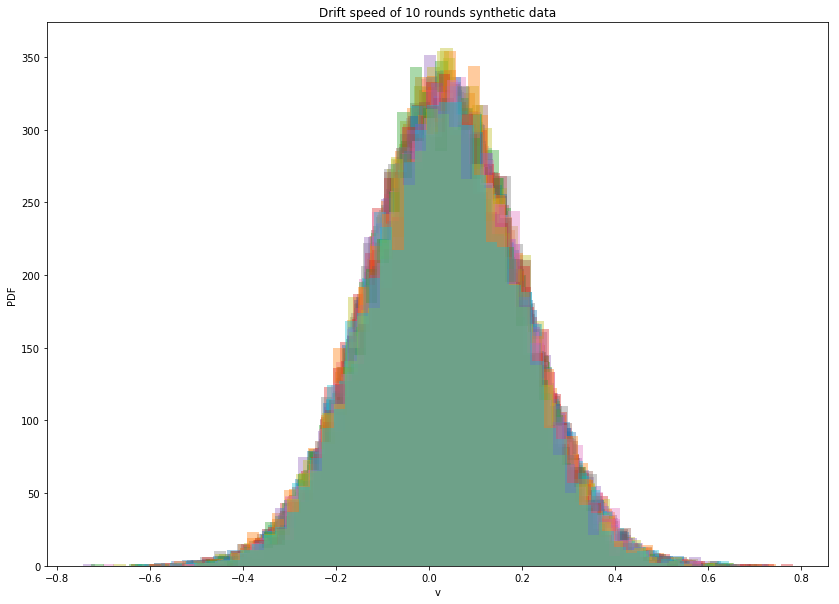

In [173]:
plt.figure(figsize = (14,10))
for m in models:
    sns.distplot(m.get_traces().v, kde = False)
plt.ylabel("PDF")
plt.title("Drift speed of 10 rounds synthetic data")

Text(0.5,1,'Bias (transposed) of 10 rounds synthetic data')

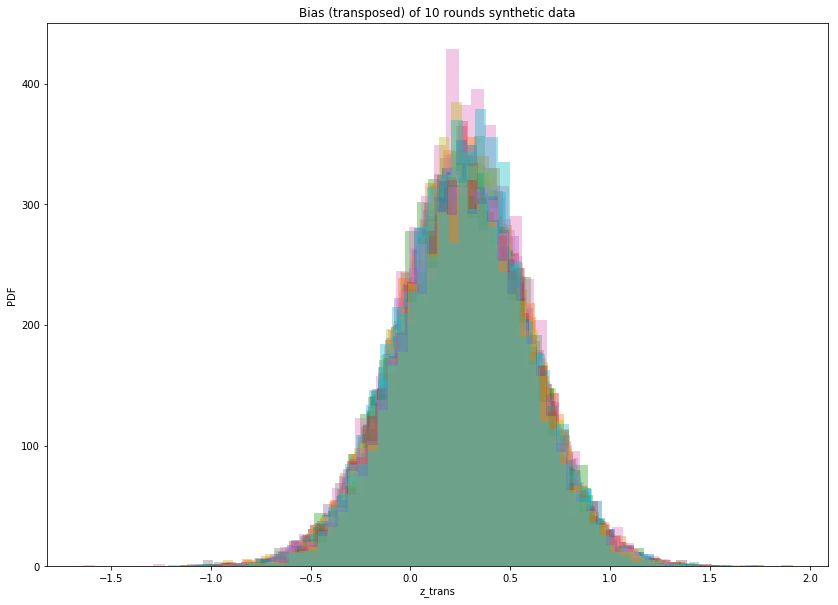

In [174]:
plt.figure(figsize = (14,10))
for m in models:
    sns.distplot(m.get_traces().z_trans, kde = False)
plt.ylabel("PDF")
plt.title("Bias (transposed) of 10 rounds synthetic data")

Plotting a
Plotting v
Plotting t
Plotting z


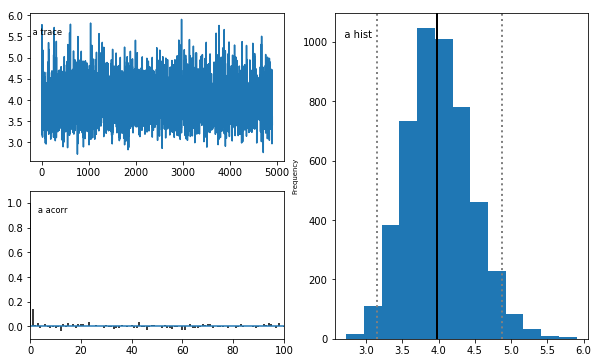

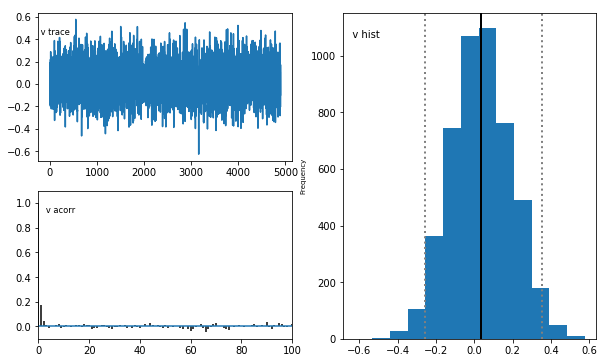

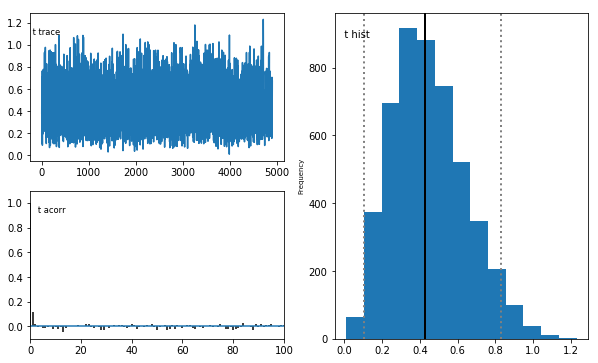

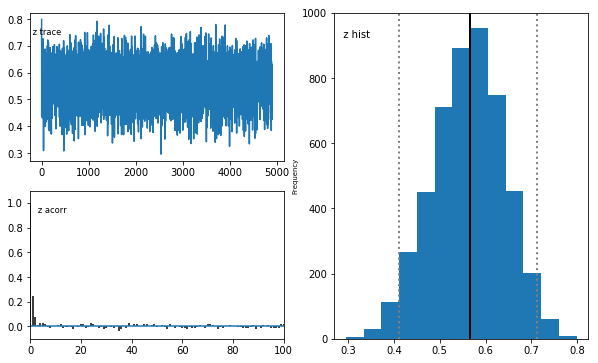

In [175]:
models[1].plot_posteriors()

In [49]:
np.mean(a_values)

5.07828422732883

In [80]:
model = hddm.HDDM(sim, bias = True)
model.sample(1000, burn = 100)
model.gen_stats()

KeyboardInterrupt: 